In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
tensor_transform = transforms.ToTensor()
dataset = datasets.MNIST(root="../data", train=True, download=True, transform=tensor_transform)
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32, shuffle=True)

100%|██████████| 9.91M/9.91M [00:03<00:00, 2.94MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 91.9kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 885kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.6MB/s]


In [3]:
class MRL_Autoencoder(nn.Module):
    def __init__(self, latent_dim=10):
        super(MRL_Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim),  
        )
        
        
        self.decoders = nn.ModuleList([
            nn.Sequential(
                nn.Linear(k, 64),
                nn.ReLU(),
                nn.Linear(64, 128),
                nn.ReLU(),
                nn.Linear(128, 28 * 28),
                nn.Sigmoid()
            ) for k in range(1, latent_dim + 1)
        ])
        
    def forward(self, x):
        z = self.encoder(x)  
        reconstructions = []
        for k in range(1, self.latent_dim + 1):
            z_k = z[:, :k]  
            recon = self.decoders[k - 1](z_k)
            reconstructions.append(recon)
        return z, reconstructions

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MRL_Autoencoder(latent_dim=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)
loss_function = nn.MSELoss()
epochs = 20
outputs = []
losses = [[] for _ in range(10)]

NameError: name 'MRL_Autoencoder' is not defined

In [8]:
for epoch in range(epochs):
    for images, _ in loader:
        images = images.view(-1, 28 * 28).to(device)
        
        optimizer.zero_grad()
        z, reconstructions = model(images)
        
        total_loss = 0
        for k in range(10):
            loss_k = loss_function(reconstructions[k], images)
            losses[k].append(loss_k.item())
            total_loss += loss_k
        
        total_loss.backward()
        optimizer.step()

    sample_images = images.detach().cpu()
    sample_recons = [r.detach().cpu() for r in reconstructions]
    outputs.append((epoch, sample_images, sample_recons, z))
    print(f"Epoch {epoch + 1}/{epochs}, Loss (10d): {losses[9][-1]:.6f}")

Epoch 1/20, Loss (10d): 0.015922
Epoch 2/20, Loss (10d): 0.017186
Epoch 3/20, Loss (10d): 0.016099
Epoch 4/20, Loss (10d): 0.020201
Epoch 5/20, Loss (10d): 0.015191
Epoch 6/20, Loss (10d): 0.019062
Epoch 7/20, Loss (10d): 0.021249
Epoch 8/20, Loss (10d): 0.017835
Epoch 9/20, Loss (10d): 0.019164
Epoch 10/20, Loss (10d): 0.016461
Epoch 11/20, Loss (10d): 0.016796
Epoch 12/20, Loss (10d): 0.015564
Epoch 13/20, Loss (10d): 0.017590
Epoch 14/20, Loss (10d): 0.017789
Epoch 15/20, Loss (10d): 0.017240
Epoch 16/20, Loss (10d): 0.014818
Epoch 17/20, Loss (10d): 0.019640
Epoch 18/20, Loss (10d): 0.017392
Epoch 19/20, Loss (10d): 0.016399
Epoch 20/20, Loss (10d): 0.015920


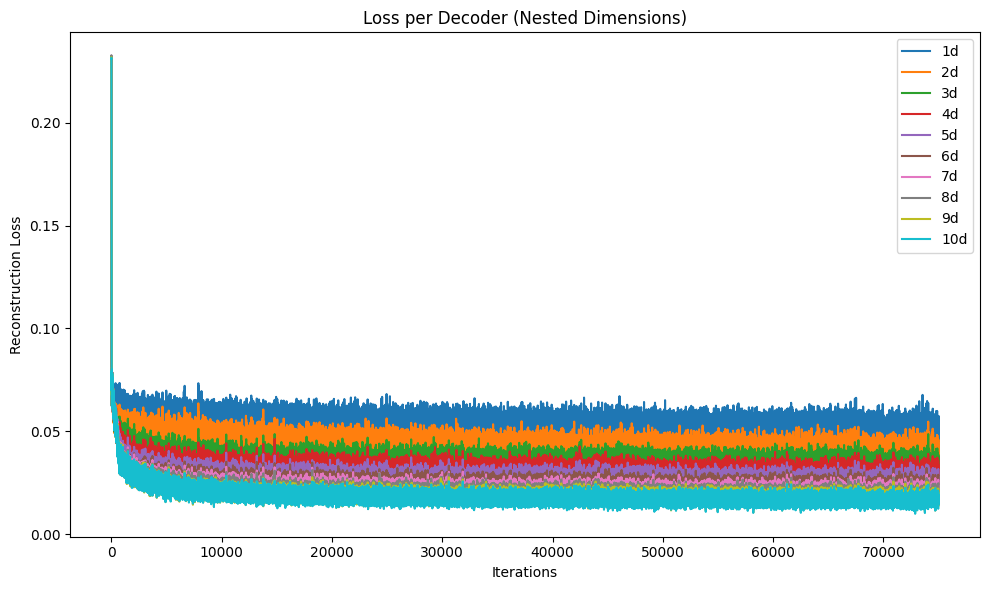

In [ ]:
plt.figure(figsize=(10, 6))
for k in range(10):
    plt.plot(losses[k], label=f"{k+1}d")
plt.xlabel("Iterations")
plt.ylabel("Reconstruction Loss")
plt.title("Loss per Decoder (Nested Dimensions)")
plt.legend()
plt.tight_layout()
plt.show()


Sample 1: [ 9.157894    2.4832582   5.645038   -0.8399528   0.68408304  2.8765552
  1.6301168   1.3934873   0.9997219  -1.5228428 ]
z_k=tensor([[ 9.1579e+00,  2.4833e+00,  5.6450e+00, -8.3995e-01,  6.8408e-01,
          2.8766e+00,  1.6301e+00,  1.3935e+00,  9.9972e-01],
        [ 2.5154e+01,  1.4431e+01,  1.2220e+01,  2.7743e+00,  6.7346e+00,
          1.1822e+01,  1.0824e+01,  7.8119e-01,  4.2341e+00],
        [-7.0157e+00, -4.0007e+00,  3.3408e+00, -2.1133e+00,  3.9047e+00,
          1.4627e+00,  3.9330e+00, -2.2931e+00,  1.7110e+00],
        [ 4.6857e+00,  7.7590e-01, -4.9019e-02, -1.2377e+00, -1.2757e+00,
          2.2105e+00,  1.7785e+00, -3.2579e-01,  3.3825e-01],
        [ 1.8757e+00, -4.1782e-02,  9.6866e-02, -4.8997e+00,  8.5171e-01,
          7.4893e-02,  3.5159e-01, -9.3191e-01,  3.5331e-04],
        [ 1.5298e+00, -5.5622e-01,  2.8915e-01, -4.7757e+00,  2.1482e+00,
          8.9066e-01,  3.5202e-01, -5.4532e-01, -5.6951e-01],
        [ 2.3104e+00,  1.9773e+00,  1.4306e+00, 

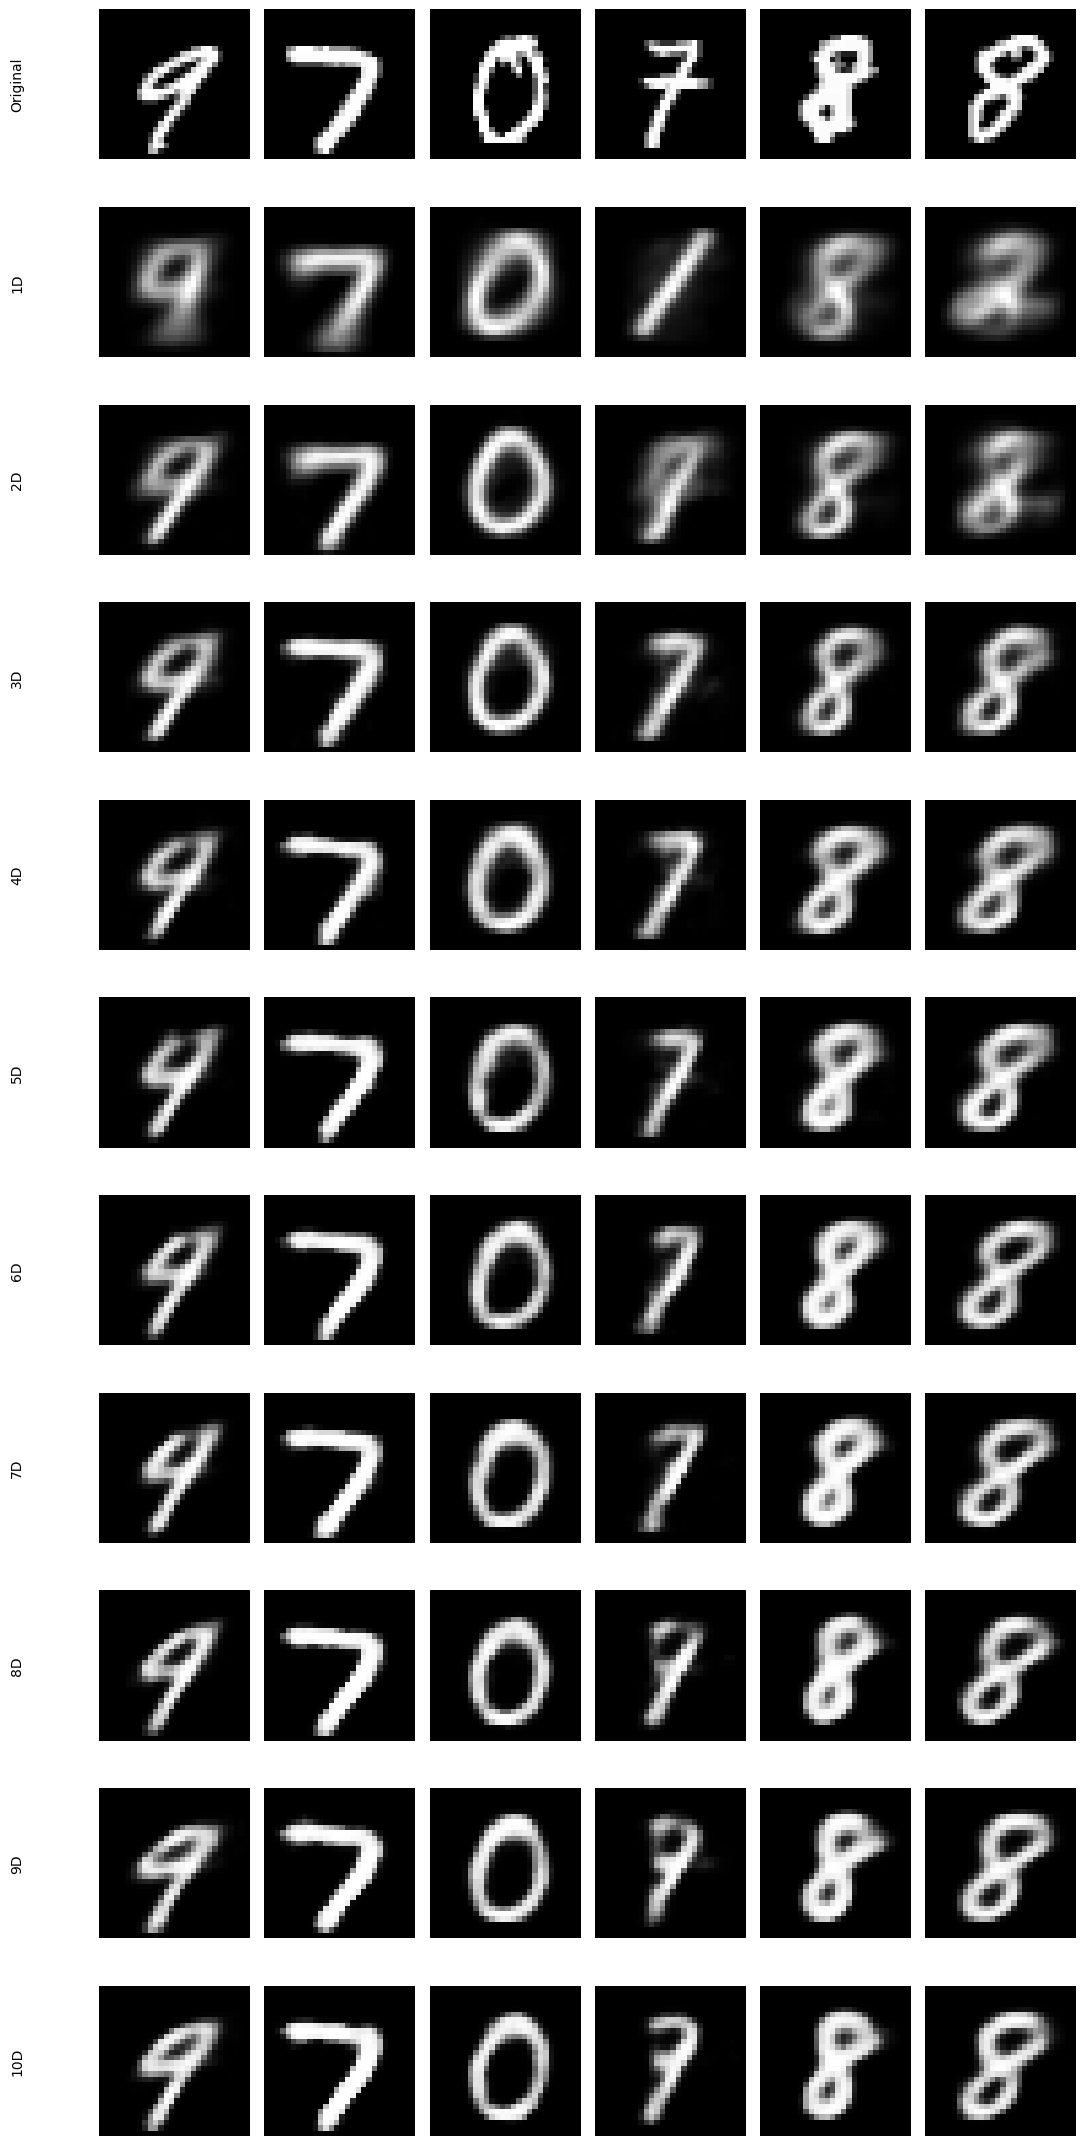

In [19]:
epoch_idx, original_imgs, recon_imgs_list, latent_vecs = outputs[-1]

n = min(6, original_imgs.size(0))  
original_imgs = original_imgs[:n].view(-1, 28, 28)
recon_imgs_list = [recon[:n].view(-1, 28, 28) for recon in recon_imgs_list]

z_k = latent_vecs[:, :k]
latent_vecs = latent_vecs[:n].detach().cpu().numpy()


for i in range(n):
    print(f"Sample {i + 1}: {latent_vecs[i]}")
    print(f"{z_k=}")

image_sets = [("Original", original_imgs)] + [(f"{k+1}D", recon_imgs_list[k]) for k in range(10)]

rows = len(image_sets)
plt.figure(figsize=(1.8 * n, 2 * rows))

for row, (title, img_batch) in enumerate(image_sets):
    for col in range(n):
        ax = plt.subplot(rows, n, row * n + col + 1)
        ax.imshow(img_batch[col], cmap='gray')
        ax.axis('off')
        if col == 0:
            ax.text(-0.5, 0.5, title, fontsize=10, va='center', ha='right',
                    transform=ax.transAxes, rotation=90)

plt.tight_layout()
plt.show()


In [20]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=10):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim),  
        )
        
        self.sub_decoder = nn.Sequential(
            nn.Linear(5, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        z = self.encoder(x)  
        recon = self.decoder(z)
        sub_recon = self.sub_decoder(z[:, :5])
        return z, recon, sub_recon

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = Autoencoder(latent_dim=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)
loss_function = nn.MSELoss()
epochs = 20
outputs = []
losses = [[] for _ in range(10)]

cuda


In [22]:
# for epoch in range(epochs):
#     for images, _ in loader:
#         images = images.view(-1, 28 * 28).to(device)
        
#         optimizer.zero_grad()
#         z, recon = model(images)
        
#         total_loss = 0
#         # for k in range(10):
#         #     loss_k = loss_function(reconstructions[k], images)
#         #     losses[k].append(loss_k.item())
#         #     total_loss += loss_k
#         loss = loss_function(recon, images)
#         total_loss += loss
        
#         total_loss.backward()
#         optimizer.step()

#     sample_images = images.detach().cpu()
#     sample_recon = recon.detach().cpu()
#     outputs.append((epoch, sample_images, sample_recon, z))
#     print(f"Epoch {epoch + 1}/{epochs}, Loss (10d): {losses[-1]:.6f}")

for epoch in range(epochs):
    for images, _ in loader:
        images = images.view(-1, 28 * 28).to(device)

        z, recon, sub_recon = model(images)
        loss = loss_function(recon, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    outputs.append((epoch, images, recon, sub_recon))
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.6f}")

Epoch 1/20, Loss: 0.032447
Epoch 2/20, Loss: 0.023051
Epoch 3/20, Loss: 0.019660
Epoch 4/20, Loss: 0.017050
Epoch 5/20, Loss: 0.018047
Epoch 6/20, Loss: 0.017698
Epoch 7/20, Loss: 0.017527
Epoch 8/20, Loss: 0.015160
Epoch 9/20, Loss: 0.015983
Epoch 10/20, Loss: 0.017947
Epoch 11/20, Loss: 0.016582
Epoch 12/20, Loss: 0.015707
Epoch 13/20, Loss: 0.015423
Epoch 14/20, Loss: 0.017231
Epoch 15/20, Loss: 0.013739
Epoch 16/20, Loss: 0.017137
Epoch 17/20, Loss: 0.015491
Epoch 18/20, Loss: 0.016206
Epoch 19/20, Loss: 0.016077
Epoch 20/20, Loss: 0.015143


In [ ]:
epoch_idx, original_imgs, recon_imgs_list, latent_vecs = outputs[-1]

n = min(6, original_imgs.size(0))  
original_imgs = original_imgs[:n].view(-1, 28, 28)
recon_imgs_list = [recon[:n].view(-1, 28, 28) for recon in recon_imgs_list]

z_k = latent_vecs[:, :k]
latent_vecs = latent_vecs[:n].detach().cpu().numpy()

image_sets = [("Original", original_imgs)] + [(f"{k+1}D", recon_imgs_list[k]) for k in range(10)]

rows = len(image_sets)
plt.figure(figsize=(1.8 * n, 2 * rows))

for row, (title, img_batch) in enumerate(image_sets):
    for col in range(n):
        ax = plt.subplot(rows, n, row * n + col + 1)
        ax.imshow(img_batch[col], cmap='gray')
        ax.axis('off')
        if col == 0:
            ax.text(-0.5, 0.5, title, fontsize=10, va='center', ha='right',
                    transform=ax.transAxes, rotation=90)

plt.tight_layout()
plt.show()


In [ ]:
epoch_idx, original_imgs, recon_imgs, sub_recon_imgs = outputs[-1]

# Number of images to visualize
n = min(6, original_imgs.size(0))

# Reshape to (N, 28, 28) and move to CPU
original_imgs = original_imgs[:n].view(-1, 28, 28).cpu().detach()
recon_imgs = recon_imgs[:n].view(-1, 28, 28).cpu().detach()
sub_recon_imgs = sub_recon_imgs[:n].view(-1, 28, 28).cpu().detach()

# Create a list of image sets to visualize
image_sets = [
    ("Original", original_imgs),
    ("Reconstruction", recon_imgs),
    ("Sub-Reconstruction", sub_recon_imgs),
]

# Plotting
rows = len(image_sets)
plt.figure(figsize=(1.8 * n, 2 * rows))

for row, (title, img_batch) in enumerate(image_sets):
    for col in range(n):
        ax = plt.subplot(rows, n, row * n + col + 1)
        ax.imshow(img_batch[col], cmap='gray')
        ax.axis('off')
        if col == 0:
            ax.text(-0.5, 0.5, title, fontsize=10, va='center', ha='right',
                    transform=ax.transAxes, rotation=90)

plt.tight_layout()
plt.show()